In [2]:
import os, sys, json
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("..")
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# read from json
data = None
experiment_name = "fig3d"
with open("../../../output/prioplus-eurosys25/experiments/" + experiment_name + ".json", "r") as f:
    data = json.load(f)

In [4]:
# In this experiment, we have four flows and a bottleneck link
# Draw the send rate of each flow in subfigure1
# And draw the queue length of the bottleneck link in subfigure2

# Calculate the send rate from data{flowStatistics:[0:4]:sentPkt:[timeNs,sizeByte]}
# The send rate is calculated by the number Bytes sent in each time interval
send_rate_interval_ns = 1e4  # 10us
send_rate = []
flow_num = 4
for i in range(flow_num):
    send_rate.append([])
    wnd_start = data["flowStatistics"][i]["sentPkt"][0]["timeNs"]
    # the first point
    send_rate[i].append({"timeNs": wnd_start, "sendRateGbps": 0})
    wnd_data = 0
    for sentPkt in data["flowStatistics"][i]["sentPkt"]:
        if sentPkt["timeNs"] - wnd_start > send_rate_interval_ns:
            # Gbps = bpns
            send_rate[i].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                                "sendRateGbps": wnd_data * 8 / send_rate_interval_ns})
            wnd_start = sentPkt["timeNs"]
            wnd_data = 0
        wnd_data += sentPkt["sizeByte"]
    # the last point
    send_rate[i].append({"timeNs": wnd_start + send_rate_interval_ns/2,
                         "sendRateGbps": 0})

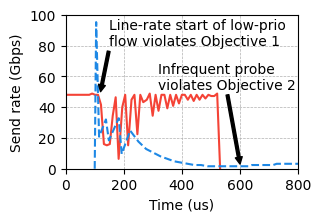

In [5]:
# draw the send rate in a new figure
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.set_xlabel("Time (us)")
ax.set_ylabel("Send rate (Gbps)")

color_rate = ["#F44336", "#1E88E5"]
color_queue = ["#4E342E", "#FB8C00"]
line = ["-", "--"]

switch_idx = 0
port_idx = 7
queue_idx = 0

time_shift = 100e3 + 25
for i in [0,1]:
    ax.plot([s["timeNs"]/1e3 - time_shift for s in send_rate[i]], [s["sendRateGbps"]
             for s in send_rate[i]], label="flow"+str(i), color=color_rate[i], linestyle=line[i])
ax.grid(True, linestyle='--', linewidth=0.5, which='both', axis='both')

ax.annotate('Line-rate start of low-prio \nflow violates Objective 1', xy=(120, 50), xytext=(150, 80),
            xycoords='data',
            arrowprops=dict(facecolor='black', shrink=0, width=2, headlength=5, headwidth=5),
            )

# make the text box at the middle of the arrow
ax.annotate('Infrequent probe \nviolates Objective 2', xy=(600, 3), xytext=(-59, 54),
            xycoords='data', textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0, width=2, headlength=5, headwidth=5),
            )
ax.set_xlim(0, 800)
ax.set_ylim(0, 100)

plt.savefig("../figures/" + experiment_name +
            ".pdf", bbox_inches='tight', dpi=600, format='pdf')